#  Прогнозирование количества заказов для сервиса заказа такси

## 1. Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

### 1.1. Цель
Спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Построить модель для такого предсказания.

*Примечание.* Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### 1.2. План работы

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.

## 2. Знакомство с данными и их ресемплирование 

Импортируем необходимые для работы библиотеки и считаем данные из файла.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 0

In [2]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

Изучим данные. Выведем на экран первые 5 строк датафрейма, вызовем для него метод `info`, а также проверим, что дата и время расположены в хронологическом порядке.

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print(f'Данные расположены в хронологическом порядке: {data.index.is_monotonic_increasing}')

Данные расположены в хронологическом порядке: True


**Выводы.**
- Данные расположены в хронологическом порядке.
- Данные о заказах такси предоставлены за временной промежуток с марта 2018 года по август того же года включительно.
- В данных нет пропусков.
- Данные о заказах такси предоставлены за каждые 10 минут, а поскольку нам надо предсказать количество заказов такси на следующий час, то и масштаб данных должен быть соответствующим. 

Сделаем ресемплирование данных с шагом в 1 час, чтобы узнать суммарное количество заказов не за каждые 10 минут, а за каждый час.

In [6]:
data = data.resample('1H').sum()

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 2. Анализ временного ряда

Построим график по данным о количестве заказов такси за каждый час и график, полученный в результате применения метода сглаживания временных рядов, называемого скользящим средним, к этим данным.

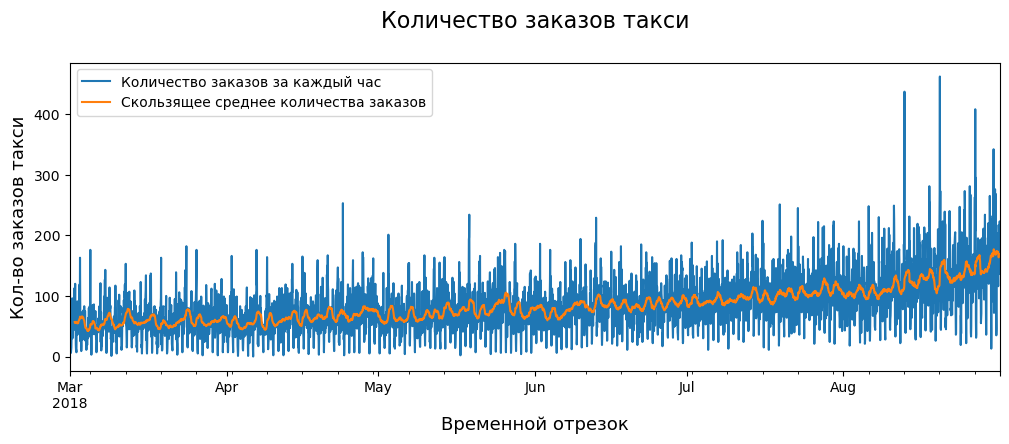

In [7]:
_, ax = plt.subplots()
data.plot(ax=ax, figsize=(12, 4))
data.rolling(24).mean().plot(ax=ax)
plt.title('Количество заказов такси\n', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13)
plt.ylabel('Кол-во заказов такси', fontsize=13)
plt.legend(['Количество заказов за каждый час', 'Скользящее среднее количества заказов']);

По графику видно, что в данных наблюдается тренд на увеличение количества заказов такси. Рост количества заказов также может носить сезонный характер, то есть количество заказов начинает увеличиваться с весны и до конца лета, а потом спадает осенью-зимой, однако, чтобы увидеть подобную закономерность в распоряжении должны иметься данные минимум за 1 год, а так как их нет, то мы считаем, что в данном случае рост числа заказов такси - это тренд.

Теперь разложим данные на 3 составляющие, включая тренд и сезонность, чтобы проверить есть ли в данных закономерности, которые на предыдущем графике не видны. 

In [8]:
data_decomposed = seasonal_decompose(data)

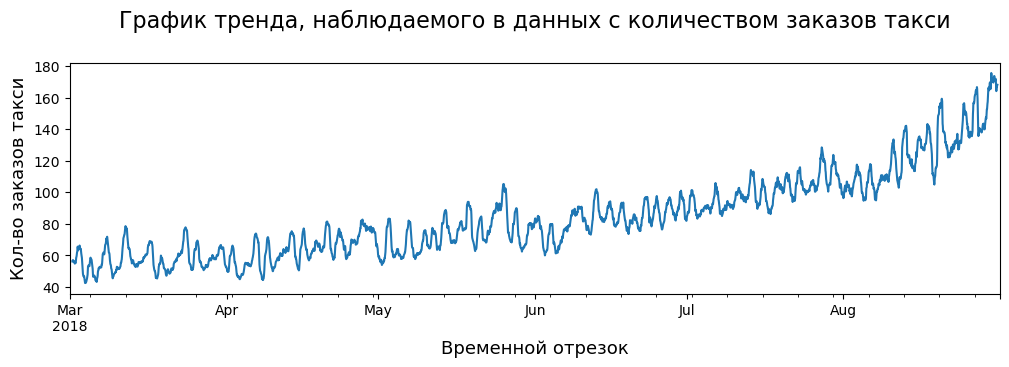

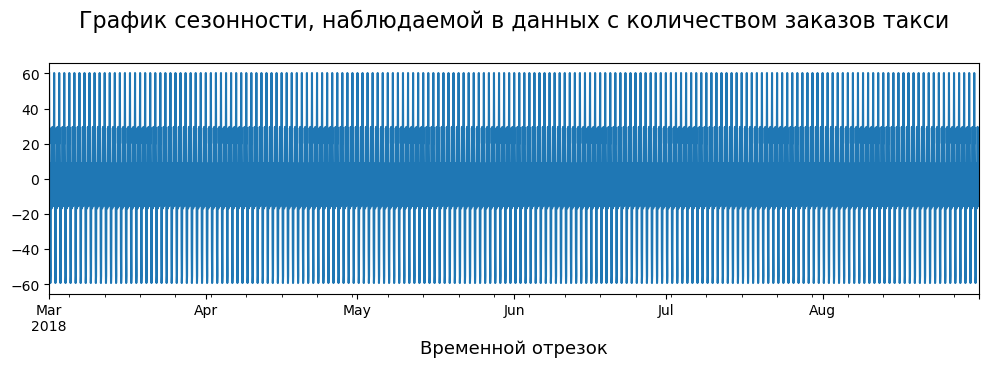

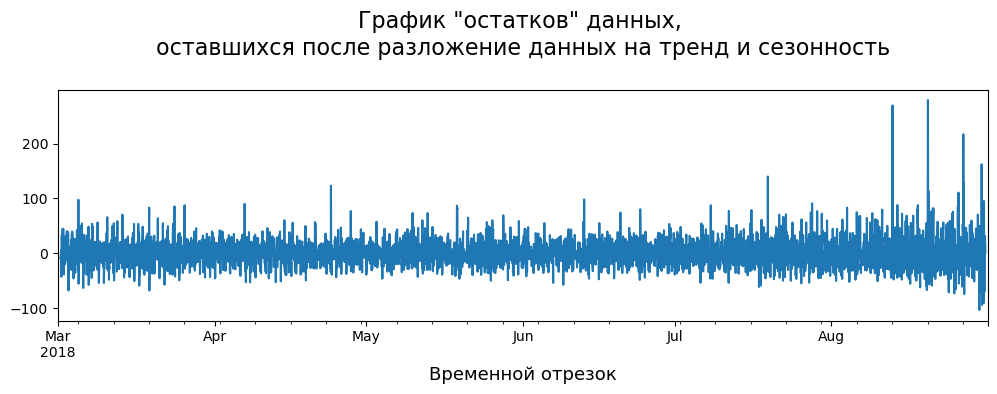

In [9]:
data_decomposed.trend.plot(figsize=(12, 3), title='Тренд');
plt.title('График тренда, наблюдаемого в данных с количеством заказов такси\n', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13)
plt.ylabel('Кол-во заказов такси', fontsize=13)
plt.show()

data_decomposed.seasonal.plot(figsize=(12, 3))
plt.title('График сезонности, наблюдаемой в данных с количеством заказов такси\n', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13)
plt.show()

data_decomposed.resid.plot(figsize=(12, 3))
plt.title('График "остатков" данных, \nоставшихся после разложение данных на тренд и сезонность\n', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13);

По графику тренда видно, что темп роста количества заказов такси немного увеличивается с начала июля, по сравнению с предыдущими месяцами, а затем становится ещё быстрее в августе. А по графику "остатков" можно сказать, что в августе данных, которые не объясняются ни трендом, ни сезонностью, стало больше. 

Судя по графику сезонности, эта составляющая колеблется в течение дня, поэтому построим график сезонности за 10 дней, чтобы увидеть форму колебаний, и за 1 день, чтобы была видна зависимость количества заказов от времени.

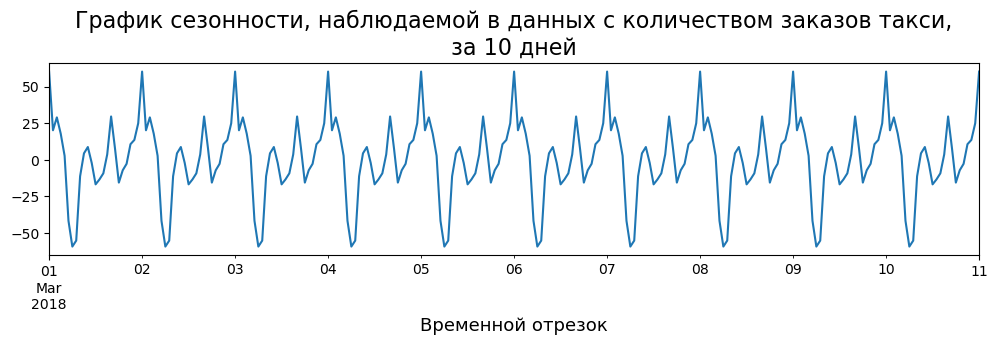

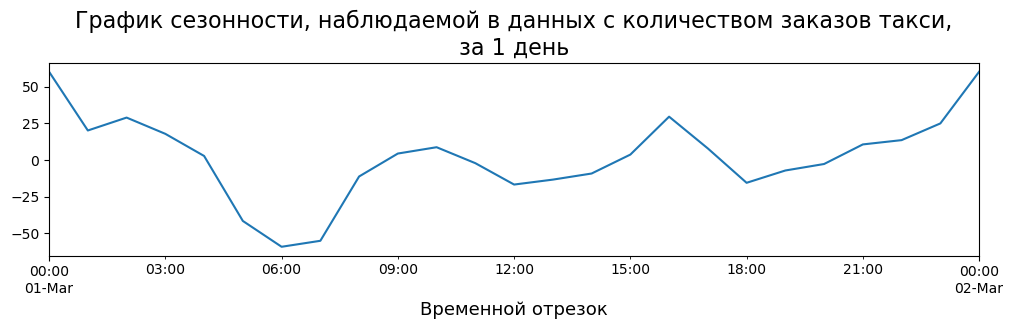

In [10]:
data_decomposed.seasonal['2018-03-01 00:00:00':'2018-03-11 00:00:00'].plot(figsize=(12, 2.5))
plt.title('График сезонности, наблюдаемой в данных с количеством заказов такси,\nза 10 дней', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13)
plt.show()

data_decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(figsize=(12, 2.5), title='Сезонность (1 день)')
plt.title('График сезонности, наблюдаемой в данных с количеством заказов такси,\nза 1 день', fontsize=16)
plt.xlabel('Временной отрезок', fontsize=13);

Видим, что каждый день в данных о количестве заказов такси наблюдается одна и та же закономерность. 
- С 6 до 10 часов количество заказов увеличивается, причём самый сильный рост наблюдается с 7 до 8 часов, то есть в час пик.
- С 10 и до 12 часов количество заказов такси уменьшается, что может быть обусловлено началом рабочего дня у большинства людей.
- С 12 и до 16 часов количество заказов увеличивается. 
- С 16 и до 18 часов количество заказов уменьшается.
- С 18 и до 24 часов количество заказов растёт; рост после 18 часов, вероятно, обусловлен окончанием рабочего дня у большого числа людей. 
- С 0 и до 1 часа ночи количество заказов уменьшается.
- С 1 и до 2 часов количество заказов немного увеличивается.
- С 2 и до 6 часов количество заказов продолжает уменьшаться.

## 3. Обучение моделей

### 3.1. Подбор параметров для создания признаков для обучения моделей

Для предсказания временного ряда нам необходимо создать признаки, на которых модели будут обучаться. 

Напишем функцию `make_features` для создания признаков, на которых модель будет обучаться. У этой функции помимо самого датафрейма будут ещё 2 параметра: `max_lag`, отвечающий за количество "отстающих" признаков, которые получают путём сдвига значений целевого признака, тем самым имитируя наличие предыдущих значений временного ряда, и `rolling_mean_size`, который задаёт размер окна для вычисления среднего скользящего, задающего общий тренд временного ряда. От этих параметров зависит вид признаков, на которых модели будут обучаться, а значит зависит и само качество моделей. 

Внутри функции, кроме "отстающих" признаков и среднего скользящего, также будут создаваться признаки номера дня месяца, дня недели и часа, когда были сделаны заказы, которые тоже могут быть полезны для предсказания значений нашего временного ряда. 

Параметр `rolling_mean_size` возьмём равным 6; такая небольшая ширина окна скользящего среднего позволит улавливать краткосрочные колебания в данных. А чтобы подобрать параметр `max_lag`, построим график автокорреляции временного ряда.

In [11]:
# Функция для создания признаков из временного ряда для обучения моделей
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    
    return data

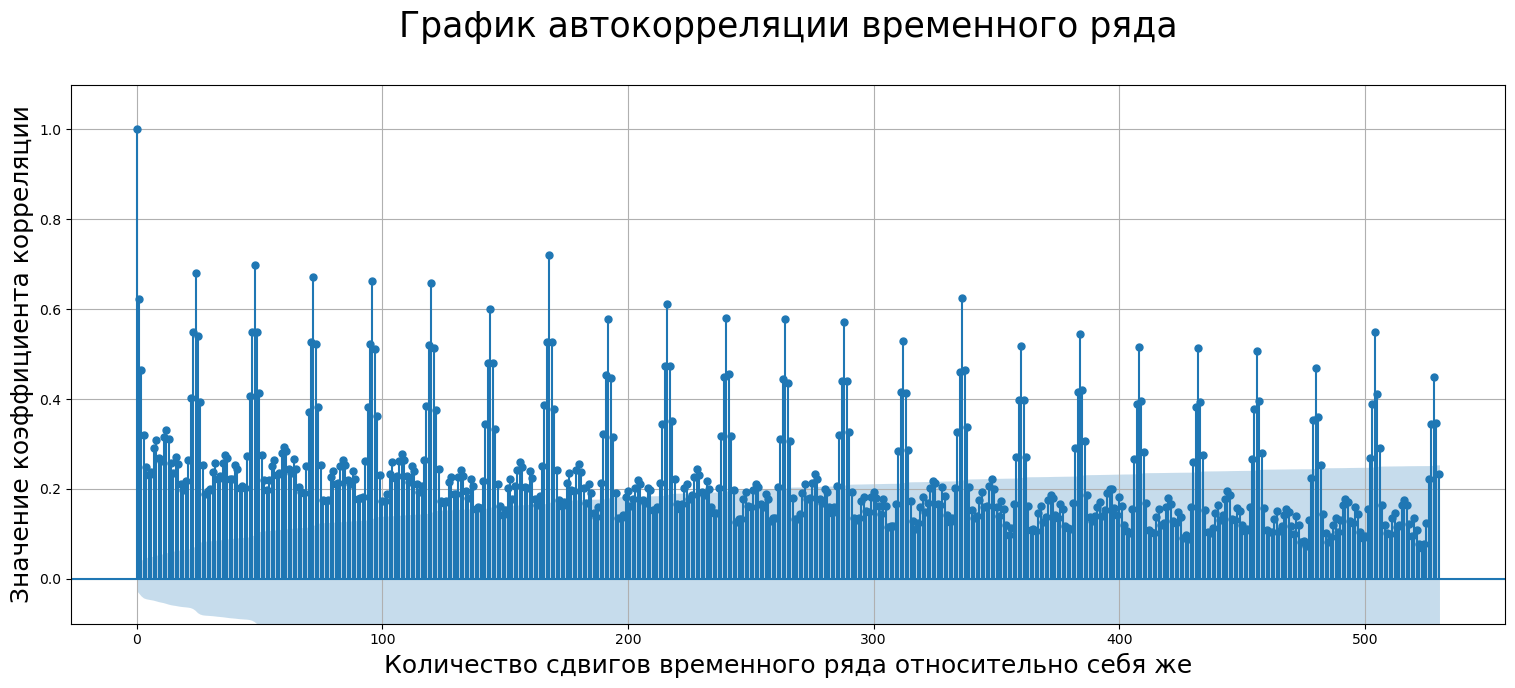

In [12]:
fig = tsaplots.plot_acf(data['num_orders'], lags=530)
fig.set_size_inches(18.5, 7)
plt.ylim(-.1, 1.1)
plt.grid(True)
plt.title('График автокорреляции временного ряда\n', fontsize=25)
plt.xlabel('Количество сдвигов временного ряда относительно себя же', fontsize=18)
plt.ylabel('Значение коэффициента корреляции', fontsize=18);

По графику автокорреляции видно, что как мы ранее уже узнали, в данных присутствует ежедневная сезонность. Но по этому графику также заметно присутствие и еженедельной сезонности: корреляция исходного временного ряда с лагами 168, 336 и 504, соответствующими сдвигам временного ряда на 7, 14 и 21 день, явно выше, чем корреляция временного ряда с лагами, соответствующими сдвигам временного ряда на 6 и 8, 13 и 15, 20 и 22 дня соответственно. Таким образом, будет логично взять параметр `max_lag`, равным 170, чтобы по признакам была видна не только ежедневная, но и еженедельная сезонность.

### 2. Обучение моделей

Прежде чем приступить к обучению моделей, создадим признаки, на которых они будут обучаться, используя параметры `max_lag = 170` и `rolling_mean_size = 4`, подобранными ранее, а также разделим данные на обучающую и тестовую выборки.

Для подбора гиперпараметров будем использовать кросс валидацию. Нам необходимо добиться, чтобы значения *RMSE* было меньше 48.

In [13]:
df = make_features(data, 170, 6)
df = df.dropna()
train, test = train_test_split(df, test_size=0.1, shuffle=False)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test= test['num_orders']

In [14]:
# Перекрестный валидатор временных рядов
tscv = TimeSeriesSplit(n_splits=10)

In [15]:
%%time
# МОДЕЛЬ ЛИНЕЙНОЙ РЕГРЕССИИ

model = LinearRegression()
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', n_iter=1, 
                             param_distributions={}, refit=False)
gsearch.fit(X_train, y_train)
print(f'RMSE = {round(-gsearch.best_score_, 4)}')

i = 1
for key, value in gsearch.cv_results_.items():
    if 'split' in key:
        print(f'Итерация №{i}: RMSE =', round(-value[0], 4))
        i += 1

RMSE = 23.4528
Итерация №1: RMSE = 31.6357
Итерация №2: RMSE = 18.3353
Итерация №3: RMSE = 21.7603
Итерация №4: RMSE = 20.7623
Итерация №5: RMSE = 21.4144
Итерация №6: RMSE = 20.9017
Итерация №7: RMSE = 21.1823
Итерация №8: RMSE = 22.9568
Итерация №9: RMSE = 25.9084
Итерация №10: RMSE = 29.6706
Wall time: 443 ms


Получившееся значение RMSE - это среднее значение оценок, полученных на каждом из 10 этапов кросс-валидации. В начале, как мы видим, эти оцени достаточно хорошие и примерно равны, кроме первого случая, когда для обучения было использовано всего 10% данных, однако, на последних 2 шагах кросс-валидации значение метрики RMSE заметно ухудшается. Это, вероятно, связано с тем, что в последний месяц-полтора в данных появилось больше "остатков", которые не объясняются ни трендом, ни сезонностью. А в связи с тем, что в последние 2 недели августа, количество этих "остатков" стало ещё больше, по сравнению с предыдущими периодами, то на тестовой выборке, в которую как раз входят данные за последние 2 недели августа, стоит ожидать увеличения значения RMSE примерно до уровня оценки, полученной на последнем шаге кросс-валидации (29.6706), или даже выше.

In [16]:
%%time
# МОДЕЛЬ РЕШАЮЩЕГО ДЕРЕВА

parameters = {
    'max_depth': range(2, 101),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11)
}

model = DecisionTreeRegressor(random_state=RANDOM_STATE) 
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', n_iter=50, 
                             param_distributions=parameters, refit=False, n_jobs=-1, random_state=RANDOM_STATE)
gsearch.fit(X_train, y_train)
print(f'RMSE = {round(-gsearch.best_score_, 4)}\n Гиперпараметры модели: {gsearch.best_params_}')

RMSE = 26.1851
 Гиперпараметры модели: {'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 7}
Wall time: 17.6 s


In [17]:
%%time
# МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА

parameters = {
    'n_estimators': range(60, 1061, 40),
    'max_depth': range(5, 203, 20),
    'min_samples_leaf': range(1, 10)
} 

model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', n_iter=5, 
                             param_distributions=parameters, refit=False, n_jobs=-1, verbose=10, random_state=RANDOM_STATE)
gsearch.fit(X_train, y_train)
print(f'RMSE = {round(-gsearch.best_score_, 4)}. Гиперпараметры модели: {gsearch.best_params_}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
RMSE = 21.9552. Гиперпараметры модели: {'n_estimators': 660, 'min_samples_leaf': 1, 'max_depth': 145}
Wall time: 9min 52s


In [18]:
%%time
# МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА CatBoost

parameters = {
    'learning_rate': list(np.arange(0.1, 1, 0.1)) + [0.001, 0.01, 1],
    'depth': range(2, 11),
    'n_estimators': range(20, 1021, 50),
}

model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', n_iter=10, 
                             param_distributions=parameters, refit=False, n_jobs=-1, random_state=RANDOM_STATE)
gsearch.fit(X_train, y_train)
print(f'RMSE = {round(-gsearch.best_score_, 4)}\n Гиперпараметры модели: {gsearch.best_params_}')

RMSE = 21.9469
 Гиперпараметры модели: {'n_estimators': 370, 'learning_rate': 0.1, 'depth': 5}
Wall time: 34min 59s


In [19]:
%%time
# МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА LightGBM

parameters = {
    'learning_rate': list(np.arange(0.1, 1, 0.1)) + [0.001, 0.01, 1],
    'max_depth': range(2, 11),
    'n_estimators': range(20, 1021, 50),
    'num_leaves': range(10, 51, 5)
}

model = LGBMRegressor()
lgbm_gsearch = RandomizedSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', n_iter=40, 
                             param_distributions=parameters, n_jobs=-1, random_state=RANDOM_STATE)
lgbm_gsearch.fit(X_train, y_train)
print(f'RMSE = {round(-lgbm_gsearch.best_score_, 4)}\n Гиперпараметры модели: {lgbm_gsearch.best_params_}')

RMSE = 21.8939
 Гиперпараметры модели: {'num_leaves': 25, 'n_estimators': 470, 'max_depth': 10, 'learning_rate': 0.01}
Wall time: 4min 23s


Для всех моделей удалось добиться значения метрики RMSE в районе от 21.9 и до 26.3. При этом наименьшее значение метрики показала модель градиентного бустинга LightGBM, оно равно 21.8939. Однако, как мы помним, это усреднённая оценка, и на последних шагах кросс-валидации качество предсказаний падало, поэтому на тестовой модели также ожидается увеличение значения метрики RMSE, по сравнению с оценкой полученной при кросс-валидации.

## 4. Тестирование выбранной модели

Протестируем модель  градиентного бустинга LightGBM с гиперпараметрами `num_leaves = 25`, `n_estimators = 470`, `max_depth = 10`, `learning_rate = 0.01`. Модель с такими гиперпараметрами уже обучена и хранится в `lgbm_gsearch.best_estimator_`.

In [20]:
print(f'RMSE = {round(mean_squared_error(y_test, lgbm_gsearch.best_estimator_.predict(X_test), squared=False), 4)}')

RMSE = 36.4138


Проверим модель на адекватность: RMSE модели должно быть меньше, чем RMSE, получаемое в случае предсказания следующего значения предыдущим.

In [21]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print(f'RMSE для проверки модели на адекватность: {round(mean_squared_error(y_test, pred_previous, squared=False), 4)}')

RMSE для проверки модели на адекватность: 58.8197


Модель прошла проверку на адекватность. Но мы видим, что, как и было предположено, качество модели на тестовой выборке очень ухудшилось, однако, оно меньше 48, максимально допустимого по условию значения RMSE, поэтому эта модель может быть использована для достижения поставленной цели.

## 5. Выводы

В процессе анализа временного ряда был выявлен тренд на рост числа заказов такси и было обнаружено наличие ежедневной и еженедельной сезонности в данных с количеством заказов такси за каждый час. Также было обнаружено, что в августе увеличилось количество "остатков" данных, которые не объясняются ни трендом, ни сезонность.

Для обучения моделей были использованы следующие признаки:
- 170 "отстающих" признаков;
- скользящее среднее временного ряда с шириной окна, равной 4;
- номер дня месяца, дня недели и часа, когда были сделаны заказы такси.

Лучший результат на этапе кросс-валидации показала модель градиентного бустинга `LGBMRegressor` с гиперпараметрами `num_leaves = 25`, `n_estimators = 470`, `max_depth = 10`, `learning_rate = 0.01` и `random_state=0`. *RMSE* этой модели на кросс-валидации равно 21.8939, а вот на тестовой выборке значение метрики качества упало до 36.4138, что меньше максимально допустимого значения по условию, а значит указанная модель подходит для достижения поставленной цели. Такое ухудшение значения метрики качества, вероятно, связано с тем, что в последние 2 недели августа, количество "остатков" данных, которые не объясняются ни трендом, ни сезонностью, стало больше, по сравнению с предыдущим периодом. Поэтому на тестовой выборке, в которую как раз вошли данные за последние 2 недели августа, можно было ожидать увеличения значения *RMSE*.